In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import IPython.display as ipd

# Add Helpers to path
sys.path.append(os.path.abspath('../Model'))
import model_utils as mu

# --- CONFIGURATION ---
Select which experiment results to analyze

In [2]:
EXP_NAME = "Dropout_0.2"  # Must match the name used in Experiments_Runner
RESULTS_DIR = "../Model/results"
PREDS_CSV = os.path.join(RESULTS_DIR, f"predictions_{EXP_NAME}.csv")
MODEL_PATH = os.path.join(RESULTS_DIR, f"model_{EXP_NAME}.keras")
BASE_DATA_PATH = "../data_recordings"

print(f"Analyzing Experiment: {EXP_NAME}")
print(f"Loading predictions from: {PREDS_CSV}")

Analyzing Experiment: Dropout_0.2
Loading predictions from: ../Model/results\predictions_Dropout_0.2.csv


# Load Predictions

In [3]:

if not os.path.exists(PREDS_CSV):
    raise FileNotFoundError(f"Could not find {PREDS_CSV}. Run experiments first!")

df = pd.read_csv(PREDS_CSV)
print(f"Loaded {len(df)} test samples.")
df.head()

Loaded 1685 test samples.


,speaker_id,path,label,speaker,true_label,pred_prob,pred_label
0,p001,accepted\p001\p001_206_000.wav,1,p001,1,0.433739,0
1,p001,accepted\p001\p001_206_001.wav,1,p001,1,1.000000,1
2,p001,accepted\p001\p001_206_002.wav,1,p001,1,1.000000,1
3,p001,accepted\p001\p001_207_000.wav,1,p001,1,1.000000,1
4,p001,accepted\p001\p001_207_001.wav,1,p001,1,1.000000,1


# --- PART 1: GLOBAL METRICS ---


=== Classification Report ===
              precision    recall  f1-score   support

Rejected (0)       0.94      0.91      0.92       902
Accepted (1)       0.90      0.93      0.92       783

    accuracy                           0.92      1685
   macro avg       0.92      0.92      0.92      1685
weighted avg       0.92      0.92      0.92      1685



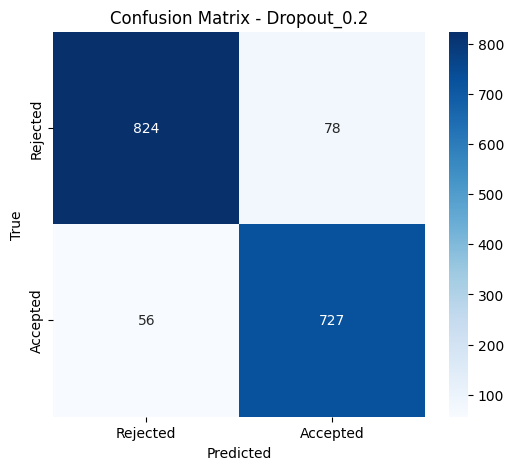

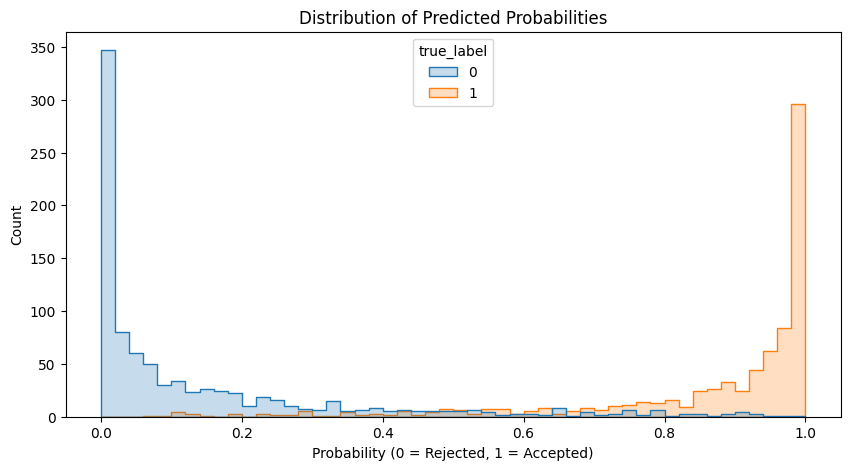

In [4]:
print("\n=== Classification Report ===")
print(classification_report(df['true_label'], df['pred_label'], target_names=['Rejected (0)', 'Accepted (1)']))

# Confusion Matrix
cm = confusion_matrix(df['true_label'], df['pred_label'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Accepted'], yticklabels=['Rejected', 'Accepted'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {EXP_NAME}')
plt.show()

# Probability Histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='pred_prob', hue='true_label', element="step", bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Probability (0 = Rejected, 1 = Accepted)")
plt.show()

# --- PART 2: ERROR ANALYSIS (HARDEST SAMPLES) ---

We define "Hard Samples" as "Confident Failures". \
Calculate "Confidence" = distance from 0.5 (uncertainty). \
But for errors, we care about high confidence in the WRONG direction. \
\
Error magnitude: |predicted_prob - true_label| \
If True=1 and Pred=0.1 -> Error=0.9 (Big error) \
If True=0 and Pred=0.9 -> Error=0.9 (Big error) 



=== TOP 10 HARDEST SAMPLES (Confident Failures) ===


,path,speaker,true_label,pred_prob,error_magnitude
842,rejected\p254\p254_128_002.wav,p254,0,0.999709,0.999709
1510,rejected\p273\p273_113_001.wav,p273,0,0.964762,0.964762
908,rejected\p256\p256_111_000.wav,p256,0,0.950462,0.950462
165,rejected\p227\p227_102_001.wav,p227,0,0.936228,0.936228
984,rejected\p258\p258_133_000.wav,p258,0,0.935090,0.935090
116,rejected\p226\p226_105_000.wav,p226,0,0.934942,0.934942
1129,accepted\p259\p259_437_002.wav,p259,1,0.070828,0.929172
1005,rejected\p258\p258_144_000.wav,p258,0,0.918884,0.918884
880,rejected\p256\p256_096_000.wav,p256,0,0.912103,0.912103
1587,rejected\p274\p274_107_000.wav,p274,0,0.910687,0.910687



Visualizing the #1 Hardest Failure:
File: rejected\p254\p254_128_002.wav
Speaker: p254
True Label: 0 | Predicted: 0.9997


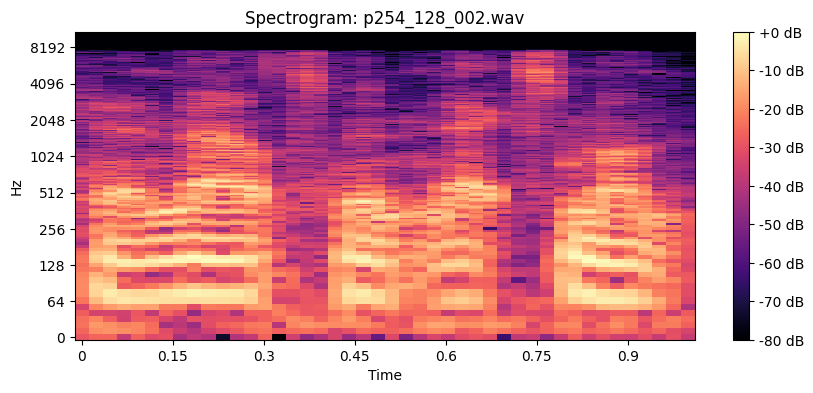

In [5]:
df['error_magnitude'] = np.abs(df['pred_prob'] - df['true_label'])

# Sort by error magnitude (descending)
hardest_samples = df.sort_values(by='error_magnitude', ascending=False).head(10)

print(f"\n=== TOP 10 HARDEST SAMPLES (Confident Failures) ===")
display(hardest_samples[['path', 'speaker', 'true_label', 'pred_prob', 'error_magnitude']])

def analyze_sample(row_index, dataframe, base_path):
    """
    Helper to visualize and listen to a specific sample.
    """
    row = dataframe.loc[row_index]
    full_path = os.path.join(base_path, row['path'])
    
    print(f"File: {row['path']}")
    print(f"Speaker: {row['speaker']}")
    print(f"True Label: {row['true_label']} | Predicted: {row['pred_prob']:.4f}")
    
    # Load audio
    y, sr = librosa.load(full_path, sr=22050)
    
    # Play Audio
    ipd.display(ipd.Audio(y, rate=sr))
    
    # Plot Spectrogram
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram: {os.path.basename(row['path'])}")
    plt.show()

# Analyze the absolute hardest failure
if not hardest_samples.empty:
    print("\nVisualizing the #1 Hardest Failure:")
    analyze_sample(hardest_samples.index[0], df, BASE_DATA_PATH)
else:
    print("No errors found! (Perfect model?)")

# --- PART 3: EMBEDDINGS VISUALIZATION (Similarity Analysis) ---
"Samples that are similar to other samples from the model’s perspective"


=== Generating Embeddings (t-SNE) ===
Loading model from ../Model/results\model_Dropout_0.2.keras...
Extracting features from layer [11]: dense_4
Reloading test audio data for embedding generation...
Loading 1685 audio files...
Successfully loaded: 1685, Failed: 0
Generating Mel-Spectrograms...
Extracting embeddings...
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Embeddings shape: (1685, 128)


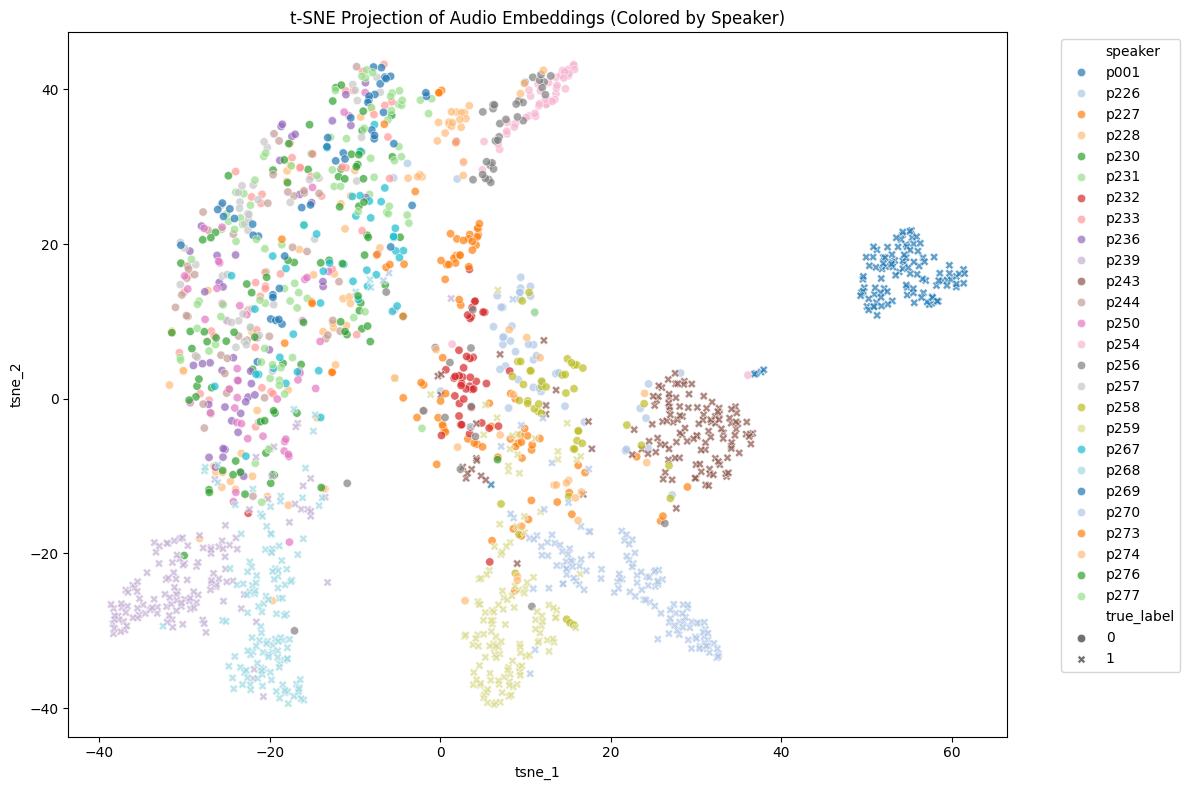

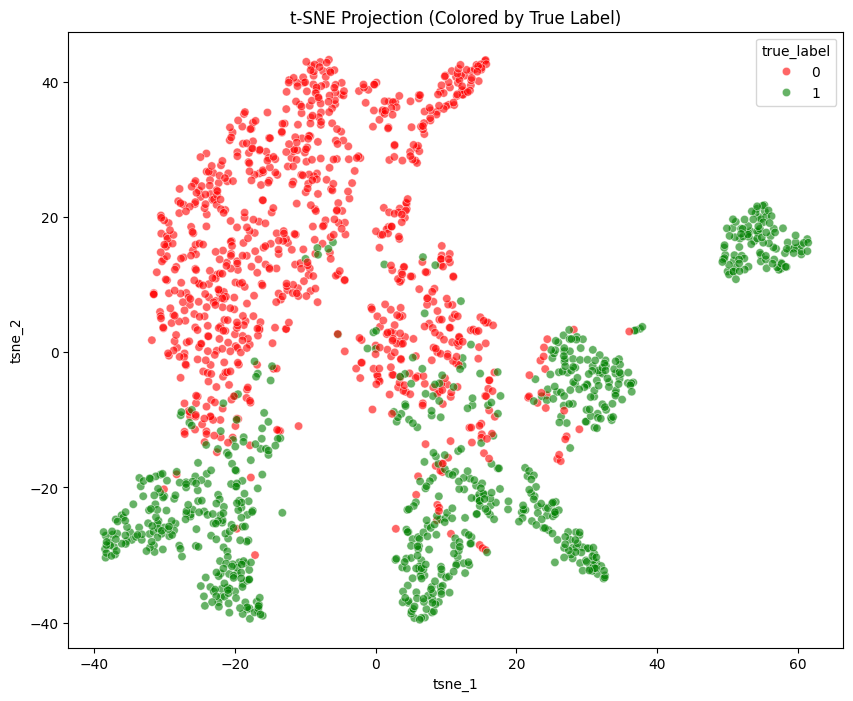

Analysis Complete.


In [6]:
# --- PART 3: EMBEDDINGS VISUALIZATION (Similarity Analysis) ---

print("\n=== Generating Embeddings (t-SNE) ===")

# 1. Load the trained model
print(f"Loading model from {MODEL_PATH}...")
model = tf.keras.models.load_model(MODEL_PATH)

# 2. Create a Feature Extractor using Model Slicing
# Instead of using Functional API (model.input), we simply create a new Sequential
# model containing the layers up to the target layer. This avoids graph connectivity errors.

target_layer_index = None

# Iterate to find the index of the specific Dense layer
for i, layer in enumerate(model.layers):
    # We look for the last Dense layer that is NOT the final output
    # (units > 1 assumes binary classification output has 1 unit)
    if isinstance(layer, tf.keras.layers.Dense) and layer.units > 1:
        target_layer_index = i
        # We keep updating to find the last one (closest to output)

# Fallback: if no hidden Dense layer found, use Flatten layer
if target_layer_index is None:
    print("No hidden Dense layer found. Looking for Flatten layer...")
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.Flatten):
            target_layer_index = i

if target_layer_index is not None:
    layer_name = model.layers[target_layer_index].name
    print(f"Extracting features from layer [{target_layer_index}]: {layer_name}")
    
    # Construct a NEW Sequential model containing layers up to the target
    # This automatically reuses the weights from the loaded model
    feature_extractor = tf.keras.Sequential(model.layers[:target_layer_index + 1])
    
    # Optional: Build the model to silence warnings (assuming standard shape)
    # (128 mels, 130 time_steps, 1 channel)
    try:
        feature_extractor.build(input_shape=(None, 128, 130, 1))
    except:
        pass # If build fails (e.g. unknown shape), predict will handle it anyway
    
else:
    raise ValueError("Could not find a suitable layer (Dense or Flatten) for embeddings.")

# 3. Reload Test Data for Feature Extraction
# We need actual audio data to generate embeddings
print("Reloading test audio data for embedding generation...")
X_test_loaded, _, _ = mu.load_and_process_data(df, BASE_DATA_PATH)

# 4. Predict Features
print("Extracting embeddings...")
embeddings = feature_extractor.predict(X_test_loaded, verbose=1)
print(f"Embeddings shape: {embeddings.shape}")

# 5. Dimensionality Reduction (t-SNE)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# 6. Visualization
df['tsne_1'] = embeddings_2d[:, 0]
df['tsne_2'] = embeddings_2d[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='tsne_1',
    y='tsne_2',
    hue='speaker', 
    style='true_label',
    palette='tab20',
    alpha=0.7
)
plt.title("t-SNE Projection of Audio Embeddings (Colored by Speaker)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize by Class separability
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='tsne_1',
    y='tsne_2',
    hue='true_label',
    palette={0: 'red', 1: 'green'},
    alpha=0.6
)
plt.title("t-SNE Projection (Colored by True Label)")
plt.show()

print("Analysis Complete.")